<a id='setup'></a>
### Set up the environment by importing libraries
import numpy, pandas, scipy, matplotlib and other libraries to set up an environment

In [150]:
%matplotlib inline
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point, MultiPoint
from numpy import random
from sklearn.neighbors import KDTree
import multiprocessing as mp
import geopandas as gpd

%matplotlib inline
%config InlineBackend.figure_formats = ['png']

#### LandScan Population Distribution
LandScan data is preprocessed and excluded the regions with no night-time population. Each point in this dataset represents the population aggregated to the centroid of the corresponding grid cell.

In [151]:
%%time
ls = gpd.read_file("./phx_data/spatial_units_with_attr.shp")
ls.head()

Wall time: 299 ms


,pointid,popval,hm_revco,hm_rting_m,fd_revco,fd_rting_m,bt_revco,bt_rating_,at_revco,at_rating_,geometry
0,82,1,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12454331.864 4023767.803)
1,84,1,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12452476.539 4023767.803)
2,186,9,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12482161.736 4022649.388)
3,295,3,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12505353.297 4021531.083)
4,296,2,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12504425.635 4021531.083)


In [152]:
ls['easting'] = ls.geometry.x
ls['northing'] = ls.geometry.y

In [153]:
##value_field = 'hm_revco'
#value_field = 'fd_revco'
#value_field = 'bt_revco'
value_field = 'at_revco'

In [154]:
total_pop = sum(ls[value_field])
print("The number of records is ", len(ls))
print("The total automotive review counts are ", total_pop)

The number of records is  6386
The total automotive review counts are  870416


#### Candidate Billboard Location
Billboards data were retrieved from LAMAR

In [155]:
sitedf = pd.read_csv("./phx_data/billboards_phx.csv")
sites = np.array(sitedf[['POINT_X', 'POINT_Y']], dtype=np.float64)

print("The number of billboards in Phoenix area is ", sites.shape[0])
sitedf.head(3)

The number of billboards in Phoenix area is  2374


,OBJECTID,id,lat,long,cbsaName,cbsaGUID,plantId,tabID,panelID,panelNumbe,hoverText,heading,weeklyImpr,productTyp,POINT_X,POINT_Y
0,1,673679,33.434264,-111.905819,"Phoenix-Mesa-Scottsdale, AZ",1B30156E-10EE-DD11-BFE8-001EC9ACE3EE,1001371102,30576923,996453,30001,LOOP 202 S/L JST W/O LOOP 101 #1 (02-1W),W,624098,BULLETINS,-12457298.79,3953088.126
1,2,673679,33.434264,-111.905819,"Phoenix-Mesa-Scottsdale, AZ",1B30156E-10EE-DD11-BFE8-001EC9ACE3EE,1001371102,30576922,996454,30002,LOOP 202 S/L JST W/O LOOP 101 #1 (02-1E),E,486407,BULLETINS,-12457298.79,3953088.126
2,3,673681,33.434756,-111.902450,"Phoenix-Mesa-Scottsdale, AZ",1B30156E-10EE-DD11-BFE8-001EC9ACE3EE,1001371102,30576894,996455,10001,LOOP 202 JUST W/O LOOP 101 #3 (01-3E),E,238586,Digital,-12456923.75,3953153.756


#### Coverage of Candidate Billboards
We setup an spatial index to help counting the population covered within specified radius of the Billboards.

In [156]:
tree = KDTree(ls[['easting', 'northing']].values)

In [157]:
def billboards_covering_pop(bbs, pop, radius):
    if type(bbs) == pd.core.frame.DataFrame:
        bbs = bbs[['POINT_X', 'POINT_Y']].values
    idx = tree.query_radius(bbs, radius, count_only=False, return_distance=False)
    pop_served = [sum(pop.iloc[idx[i]][value_field]) for i in range(len(bbs))]
    return pop_served

Counting the population served within 1000m of the POIs.

In [158]:
%%time
pop_covered = billboards_covering_pop(sites, ls, 1000)
sum(pop_covered)

Wall time: 907 ms


2757963

#### Visualization of the input data

In [159]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])
    
    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]  
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit, 
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [160]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [161]:
sitedf1 = sitedf[sitedf['POINT_X'] < max(ls['easting'])]
sitedf1 = sitedf1[sitedf1['POINT_X'] > min(ls['easting'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] < max(ls['northing'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] > min(ls['northing'])]

Wall time: 385 ms


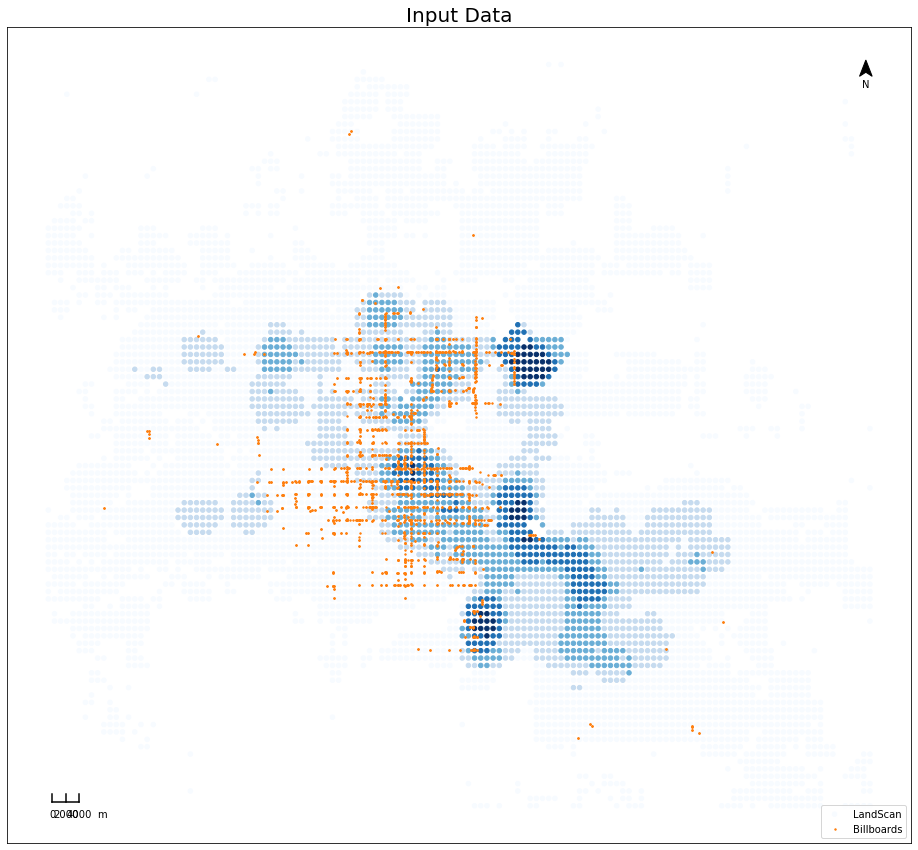

In [162]:
%%time
fig, ax = plt.subplots(figsize=(20,15))

ls.plot(ax = ax, column=ls[value_field], scheme = 'natural_breaks', k=5, markersize=20, cmap='Blues', label = 'LandScan')
ax.scatter(sitedf1['POINT_X'], sitedf1['POINT_Y'], c='C1', s=2, label = 'Billboards')

ax.axis('scaled')
ax.tick_params(axis='both', left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

ax.set_title("Input Data", fontsize=20)
render_scale_bar(ax = ax, x=0.05, y=0.05)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
ax.legend(loc='lower right', markerscale = 1)

In [163]:
def distance_matrix_binary(x, y, r):
    x = np.asarray(x)
    y = np.asarray(y)
    (M, k) = x.shape
    (N, kk) = y.shape
    if k != kk:
        raise ValueError('The length of the second dimensions of x and y must be equal'
                         )
    if r < 0:
        raise ValueError('Radius must be a non-negative number.')
    mat = np.zeros((M, N), dtype=bool)
    if M < N:
        tree = KDTree(y)
        idx = tree.query_radius(x, r, count_only=False,
                                return_distance=False)
        for i in range(M):
            mat[i, idx[i]] = 1
        return mat
    else:
        tree = KDTree(x)
        idx = tree.query_radius(y, r, count_only=False,
                                return_distance=False)
        for i in range(N):
            mat[idx[i], i] = 1
        return mat

<a id='MCLP'></a>
### Solving Maximal Covering Location Problem (MCLP)

In [164]:
## GUROBI ENV
from gurobipy import *
import time

In [165]:
def generate_candidate_sites(sites, M=100, heuristic = None):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic: 
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    if M is not None:
        if M > len(sites):
            M = None
    if heuristic is None or heuristic == '':
        if M is None:
            return sites
        index = np.random.choice(len(sites), M)
        return sites.iloc[index]
    elif heuristic == 'coverage':
        sites = sites.sort_values(by='pop_covered_2km', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'coverage_e':
        sites = sites.sort_values(by='pop_covered_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression':
        sites = sites.sort_values(by='weeklyImpr', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression_e':
        sites = sites.sort_values(by='weeklyImpr_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]

In [166]:
def mclp_landscan_ex_gurobi(ls, bbs, current_bbs, K, radius, M, heuristic=''):
    """
    Solve maximum covering location problem
    Input:
        ls: landscan dataset, Pandas DataFrame
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """

    print('----- Configurations -----')
    print('Number of points %g' % len(ls))
    print('Number of billboards %g' % len(bbs))
    print('Number of current billboards %g' % len(current_bbs))
    print('Number of selected billboards - K %g' % K)
    print('Billboard coverage Radius %g (Meter)' % radius)
    print('Number of candidate billboard sampled - M %g' % M)

    bbs_ = generate_candidate_sites(bbs, M, heuristic)
    
    #print(len(bbs_))
    current_bbs = pd.DataFrame(current_bbs, columns=['POINT_X','POINT_Y'])
    current_bbs['current'] = True
    bbs_.loc['current'] = False
    bbs = current_bbs.append(bbs_, ignore_index=True, verify_integrity=True)
    bbs = bbs.reset_index()

    J = len(bbs)  # indexing for facility sites
    I = len(ls)  # indexing for population (clients)
    D = distance_matrix_binary(ls[['easting', 'northing']].values, bbs[['POINT_X', 'POINT_Y']].values, radius)

    pop = ls[value_field]
    start = time.time()

    # Build model
    m = Model()

    # Add variables
    x = {}
    y = {}

    current = len(current_bbs)

    for i in range(I):
        y[i] = m.addVar(vtype=GRB.BINARY, name='y%d' % i)

    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name='x%d' % j)

    m.update()

    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for j in range(current):
        m.addConstr(x[j] == 1)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i] == 1)[0])
                    >= y[i])

    m.setObjective(quicksum(y[i] * pop[i] for i in range(I)),
                   GRB.MAXIMIZE)

    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()

    # print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x == 1 and v.varName[0] == 'x':
                solution.append(int(v.varName[1:]))

    opt_bbs = bbs.iloc[solution]
    return (opt_bbs, m.objVal)


In [167]:
ls.head(5)

,pointid,popval,hm_revco,hm_rting_m,fd_revco,fd_rting_m,bt_revco,bt_rating_,at_revco,at_rating_,geometry,easting,northing
0,82,1,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12454331.864 4023767.803),-1.245433e+07,4.023768e+06
1,84,1,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12452476.539 4023767.803),-1.245248e+07,4.023768e+06
2,186,9,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12482161.736 4022649.388),-1.248216e+07,4.022649e+06
3,295,3,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12505353.297 4021531.083),-1.250535e+07,4.021531e+06
4,296,2,0,0.0,0,0.0,0,0.0,0,0.0,POINT (-12504425.635 4021531.083),-1.250443e+07,4.021531e+06


In [168]:
MCLP_STAT = pd.DataFrame({
    'Heuristic': pd.Series([], dtype='str'),
    'integrate_current_sites': pd.Series([], dtype='bool'),
    'M': pd.Series([], dtype='int'),
    'radius': pd.Series([], dtype='int'),
    'K': pd.Series([], dtype='int'),
    'coverage': pd.Series([], dtype='float64'),
    'coverage_pct': pd.Series([], dtype='float64'),
    'opt_sites': pd.Series([], dtype='object')
})

In [169]:
def plot_result(ls,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20,15))
    ls.plot(ax = ax, column=ls[value_field], scheme = 'natural_breaks', k=5, markersize=1, cmap='Blues', label = 'LandScan')
    legend_plot_flag = {'current':False,'selected':False}
    
    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:#ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=1, label = 'Current Billboards')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=1, label = 'Optimized Selected Billboards')
                circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            ax.add_artist(circle)
        
    ax.axis('scaled')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m'
    ax.set_title(title, fontsize=20)
    render_scale_bar(ax = ax, x=0.05, y=0.05)
    render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
    ax.legend(loc='lower right', markerscale = 10)
    return ax

----- Configurations -----
Number of points 6386
Number of billboards 2375
Number of current billboards 0
Number of selected billboards - K 30
Billboard coverage Radius 3000 (Meter)
Number of candidate billboard sampled - M 6386
  Running time : 2.1783721446990967 seconds
  Optimal coverage points: 425199
Total population: 870416 
Covered Population: 425199.0 
Covering Ratio: 48.85009007187368 %
Wall time: 2.66 s


<AxesSubplot:title={'center':'Selected 30 Sites that Serve 3000 m'}>

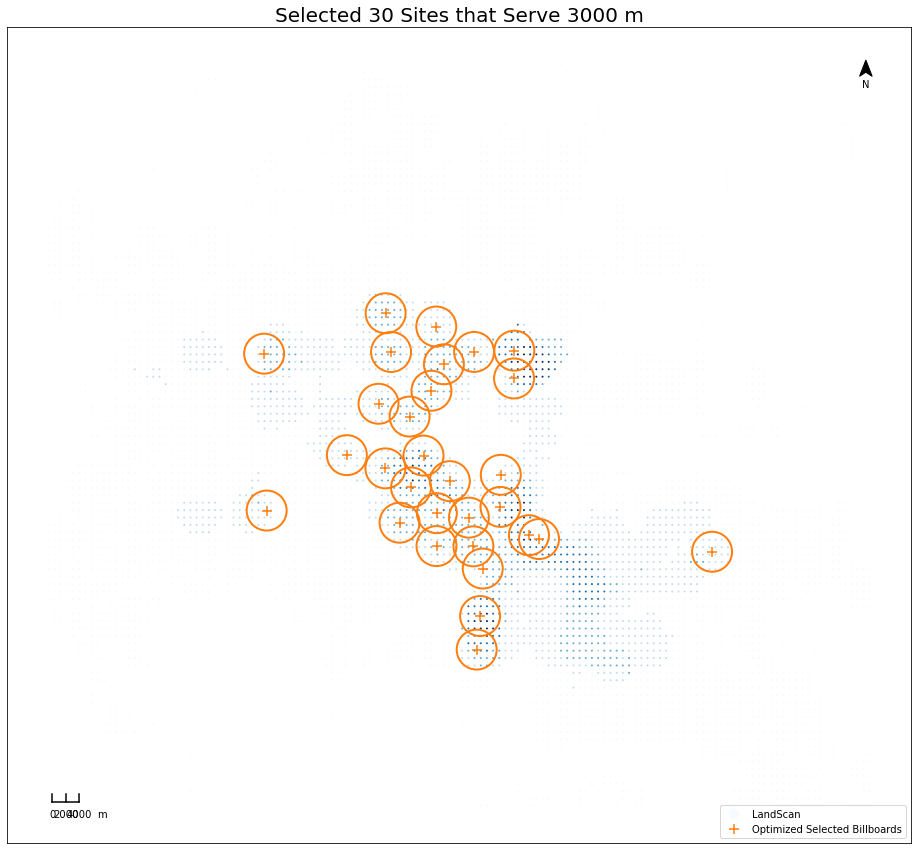

In [174]:
%%time
# Number of sites to select
K = 30

# Service radius of each site
radius = 3000

# Heuristic
heuristic = ''

# Candidate site size (random sites generated)
M = len(ls)

current_sites = []

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,n_coverage = mclp_landscan_ex_gurobi(ls, sitedf, current_sites, K, radius, M, heuristic)

print("Total population:", total_pop, '\nCovered Population:', n_coverage , '\nCovering Ratio:', n_coverage/total_pop*100, '%')

MCLP_STAT = MCLP_STAT.append({
    'Heuristic': heuristic,
    'integrate_current_sites':True,
    'M': M,
    'radius': radius,
    'K': K,
    'coverage': n_coverage,
    'coverage_pct': n_coverage/total_pop*100,
    'opt_sites': opt_sites
}, ignore_index = True)

plot_result(ls,opt_sites,radius)

In [175]:
filename = value_field + '_' + str(K) + '.csv'

opt_sites.to_csv(filename)

In [29]:
#opt_sites.head(5)

jsonStr = opt_sites[['index','lat','long','heading','productTyp','weeklyImpr']].to_json()


print(jsonStr)

{"index":{"1":1,"6":6,"49":49,"66":66,"108":108,"115":115,"131":131,"152":152,"181":181,"265":265,"274":274,"459":459,"637":637,"819":819,"877":877,"1077":1077,"1321":1321,"1331":1331,"1579":1579,"1587":1587,"1642":1642,"1739":1739,"1751":1751,"1780":1780,"1896":1896,"2060":2060,"2068":2068,"2143":2143,"2275":2275,"2279":2279},"lat":{"1":33.434264,"6":33.30614,"49":33.65801,"66":33.46199,"108":33.429901,"115":33.396685,"131":33.4156,"152":33.3432,"181":33.638795,"265":33.406695,"274":33.538293,"459":33.509749,"637":33.640993,"819":33.600692,"877":33.583193,"1077":33.487369,"1321":33.607186,"1331":33.641703,"1579":33.502195,"1587":33.552683,"1642":33.466065,"1739":33.451412,"1751":33.448269,"1780":33.640192,"1896":33.495033,"2060":33.305387,"2068":33.589568,"2143":33.65474,"2275":33.695642,"2279":33.63834},"long":{"1":-111.905819,"6":-111.7213,"49":-112.35256,"66":-112.2596,"108":-111.892211,"115":-111.968098,"131":-111.65881,"152":-111.9717,"181":-112.168505,"265":-112.046507,"274":-11

----- Configurations -----
Number of points 6386
Number of billboards 2375
Number of current billboards 0
Number of selected billboards - K 15
Billboard coverage Radius 3000 (Meter)
Number of candidate billboard sampled - M 6386
  Running time : 0.2452101707458496 seconds
  Optimal coverage points: 615260
Total population: 1722708 
Covered Population: 615260.0 
Covering Ratio: 35.7147003438772 %
Wall time: 628 ms


<AxesSubplot:title={'center':'Selected 15 Sites that Serve 3000 m'}>

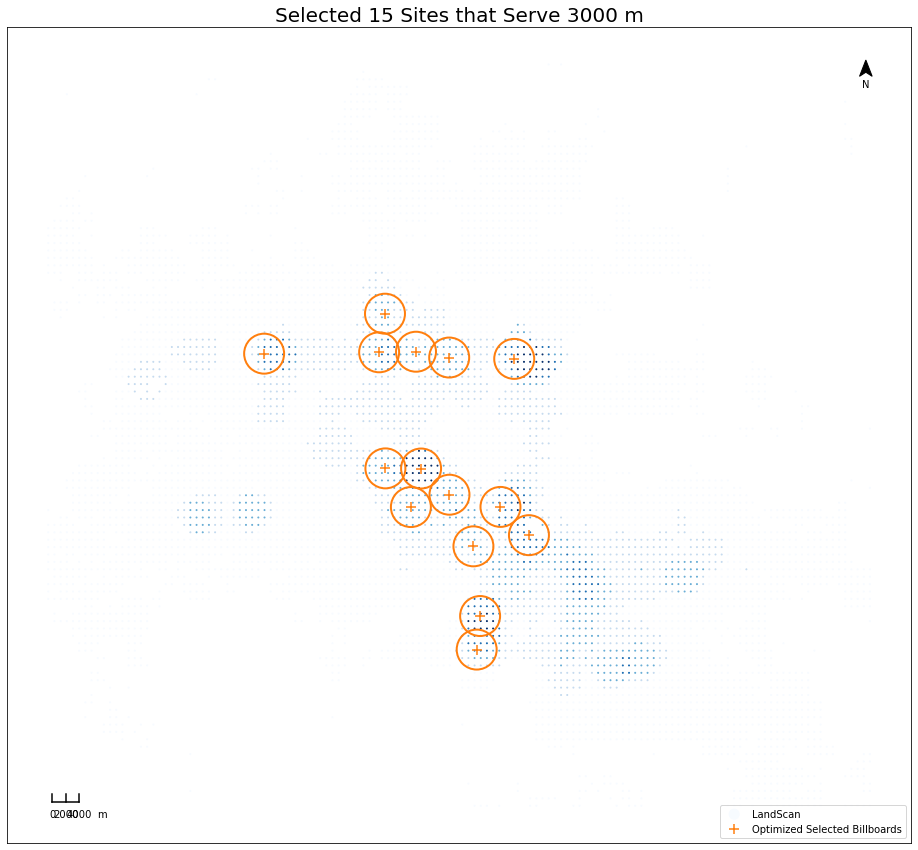

In [21]:
%%time
# Number of sites to select
K = 15

# Service radius of each site
radius = 3000

# Heuristic
heuristic = ''

# Candidate site size (random sites generated)
M = len(ls)

current_sites = []

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,n_coverage = mclp_landscan_ex_gurobi(ls, sitedf, current_sites, K, radius, M, heuristic)

print("Total population:", total_pop, '\nCovered Population:', n_coverage , '\nCovering Ratio:', n_coverage/total_pop*100, '%')

MCLP_STAT = MCLP_STAT.append({
    'Heuristic': heuristic,
    'integrate_current_sites':True,
    'M': M,
    'radius': radius,
    'K': K,
    'coverage': n_coverage,
    'coverage_pct': n_coverage/total_pop*100,
    'opt_sites': opt_sites
}, ignore_index = True)

plot_result(ls,opt_sites,radius)